<a href="https://colab.research.google.com/github/maohieng/learn_ai/blob/main/Eye_Diseases_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading Eye Diseases Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install kaggle
# !mkdir -p /content/drive/MyDrive/Colab\ Notebooks/.kaggle
# !cp /content/drive/MyDrive/Colab\ Notebooks/eye_disease_classification/kaggle.json /content/drive/MyDrive/Colab\ Notebooks/.kaggle/
# !chmod 600 /content/drive/MyDrive/Colab\ Notebooks/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

In [ ]:
# !pwd

# Current folder
currentDir = "/content/drive/MyDrive/Colab Notebooks/eye_disease_classification/"

# Listing in folder
# !ls



In [ ]:
!unzip {currentDir}/eye_diseases_classification_dataset_kaggle.zip -d {currentDir}

In [ ]:
# Install Keras
!pip install keras

In [ ]:
tf.__version__

'2.17.0'

#Importing the Necessary Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.applications import InceptionResNetV2
from keras.src.applications.inception_resnet_v2 import preprocess_input

import os
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Verify GPU available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#Creating a Combined Image Dataset with Labels

In [ ]:
data_dir = '{}dataset'.format(currentDir)

cataract_df = pd.DataFrame(columns=['filepaths', 'labels'])
diabetic_retinopathy_df = pd.DataFrame(columns=['filepaths', 'labels'])
glaucoma_df = pd.DataFrame(columns=['filepaths', 'labels'])
normal_df = pd.DataFrame(columns=['filepaths', 'labels'])

cataract_label = 'cataract'
diabetic_retinopathy_label = 'diabetic_retinopathy'
glaucoma_label = 'glaucoma'
normal_label = 'normal'


cataract_files = os.listdir(os.path.join(data_dir, "cataract"))
diabetic_retinopathy_files = os.listdir(os.path.join(data_dir, "diabetic_retinopathy"))
glaucoma_files = os.listdir(os.path.join(data_dir, "glaucoma"))
normal_files = os.listdir(os.path.join(data_dir, "normal"))


cataract_df['filepaths'] = [os.path.join(data_dir, "cataract", filename) for filename in cataract_files]
cataract_df['labels'] = cataract_label

diabetic_retinopathy_df['filepaths'] = [os.path.join(data_dir, "diabetic_retinopathy", filename) for filename in diabetic_retinopathy_files]
diabetic_retinopathy_df['labels'] = diabetic_retinopathy_label

glaucoma_df['filepaths'] = [os.path.join(data_dir, "glaucoma", filename) for filename in glaucoma_files]
glaucoma_df['labels'] = glaucoma_label

normal_df['filepaths'] = [os.path.join(data_dir, "normal", filename) for filename in normal_files]
normal_df['labels'] = normal_label


In [ ]:
combined_df = pd.concat([cataract_df, diabetic_retinopathy_df], ignore_index=True)
combined_df = pd.concat([combined_df, glaucoma_df], ignore_index=True)
combined_df = pd.concat([combined_df, normal_df], ignore_index=True)

combined_df = combined_df.sample(frac=1, random_state=42)
label_counts = combined_df['labels'].value_counts()

label_counts

,count
labels,
diabetic_retinopathy,1098
normal,1074
cataract,1038
glaucoma,1007


In [ ]:
combined_df.head(5)

,filepaths,labels
463,/content/drive/MyDrive/Colab Notebooks/eye_dis...,cataract
2426,/content/drive/MyDrive/Colab Notebooks/eye_dis...,glaucoma
2661,/content/drive/MyDrive/Colab Notebooks/eye_dis...,glaucoma
1483,/content/drive/MyDrive/Colab Notebooks/eye_dis...,diabetic_retinopathy
2860,/content/drive/MyDrive/Colab Notebooks/eye_dis...,glaucoma


#Exploring Data Distribution and Visualizing Images

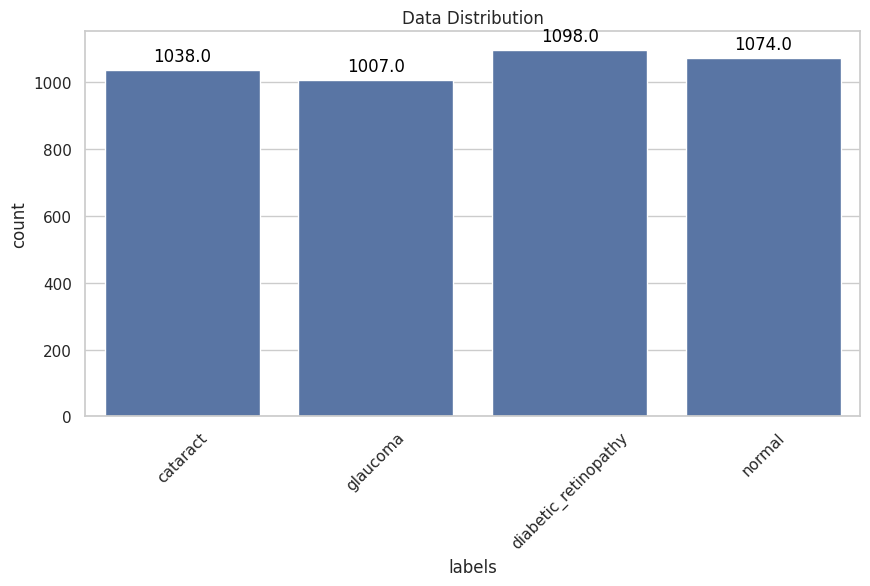

In [ ]:
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
ax = sns.countplot(data=combined_df, x='labels')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')

plt.title('Data Distribution')
plt.xticks(rotation=45)
plt.show()


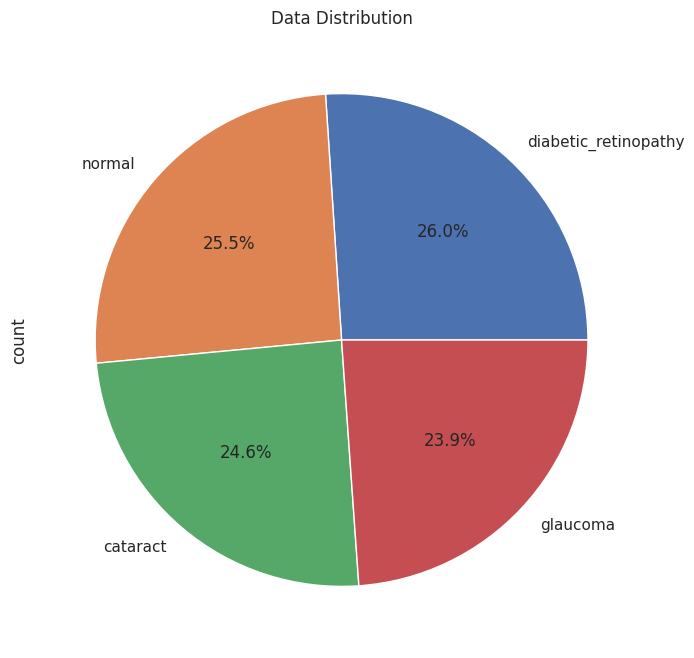

In [ ]:
plt.figure(figsize=(10, 8))
combined_df['labels'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

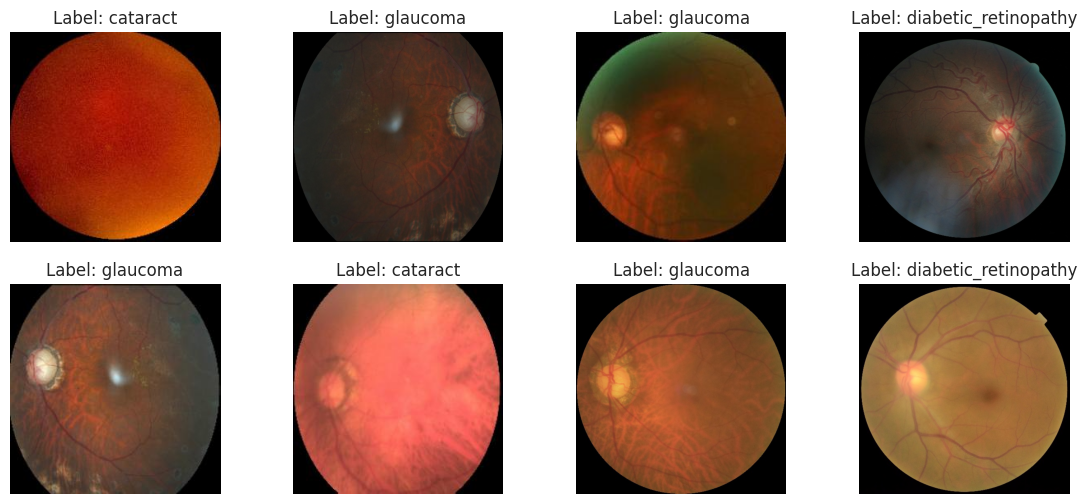

In [ ]:
def display_images(df, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6))
    for r in range(rows):
        for c in range(cols):
            index = r * cols + c
            if index < len(df):
                image_path = df.iloc[index]['filepaths']
                label = df.iloc[index]['labels']
                img = Image.open(image_path)
                axes[r, c].imshow(img)
                axes[r, c].set_title(f'Label: {label}')
                axes[r, c].axis('off')
            else:
                axes[r, c].axis('off')

    plt.show()

rows = 2
cols = 4

display_images(combined_df, rows, cols)

#Data Splitting and Class Distribution in Image Dataset

In [ ]:
train_df, dummy_df = train_test_split(combined_df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= combined_df['labels'])

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= dummy_df['labels'])

In [ ]:
train_df['labels'].value_counts()

,count
labels,
diabetic_retinopathy,878
normal,859
cataract,830
glaucoma,806


In [ ]:
test_df['labels'].value_counts()

,count
labels,
diabetic_retinopathy,110
normal,107
cataract,104
glaucoma,101


In [ ]:
valid_df['labels'].value_counts()

,count
labels,
diabetic_retinopathy,110
normal,108
cataract,104
glaucoma,100


#Data Preprocessing and Generation

In [ ]:
def scalar(img):
        return img

train_generator = ImageDataGenerator(preprocessing_function = scalar,
                                     horizontal_flip = True)

test_generator = ImageDataGenerator(preprocessing_function = scalar)

In [ ]:
train_set = train_generator.flow_from_dataframe( train_df,
                                        x_col= 'filepaths',
                                        y_col= 'labels',
                                        target_size= (224, 224),
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= 40)

Found 3373 validated image filenames belonging to 4 classes.


In [ ]:
train_set.class_indices

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

In [ ]:
valid_set = test_generator.flow_from_dataframe( valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= (224, 224),
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= 40)


Found 422 validated image filenames belonging to 4 classes.


In [ ]:
test_set = test_generator.flow_from_dataframe( test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (224, 224),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= 2)

Found 422 validated image filenames belonging to 4 classes.


#Deep Learning Models

##Transfer Learning(TL)

###InceptionResNetV2-based Neural Network Architecture

In [ ]:

# from tensorflow.keras.utils import get_file

# Load the model - local file
# Path to save the weights file
# weights_path = './inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the model architecture without weights
# base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=(224, 224, 3), pooling='max')

# Load the weights into the model
# base_model.load_weights(weights_path)

base_model = InceptionResNetV2(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

x = Dense(256, kernel_regularizer=l2(0.016), activity_regularizer=l1(0.006), bias_regularizer=l1(0.006), activation='relu')(x)
x = Dropout(rate=0.3)(x)

output = Dense(4, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = output)

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_406 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_407   │ (None, 111, 111, 32)   │             96 │ conv2d_406[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_406            │ (None, 111, 111, 32)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_407 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_406[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_408   │ (None, 109, 109, 32)   │             96 │ conv2d_407[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_407            │ (None, 109, 109, 32)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_408 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_407[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_409   │ (None, 109, 109, 64)   │            192 │ conv2d_408[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_408            │ (None, 109, 109, 64)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 54, 54, 64)     │              0 │ activation_408[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_409 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_410   │ (None, 54, 54, 80)     │            240 │ conv2d_409[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_409            │ (None, 54, 54, 80)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_410 (Conv2D)  

 Total params: 54,737,380 (208.81 MB)

 Trainable params: 54,673,764 (208.56 MB)

 Non-trainable params: 63,616 (248.50 KB)

###Training the Model

In [ ]:
history = model.fit(x= train_set,
                    epochs= 40,
                    verbose= 1,
                    validation_data= valid_set
)

Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.3234 - loss: 14.4049 - val_accuracy: 0.2607 - val_loss: 7.7562
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 66s 745ms/step - accuracy: 0.2449 - loss: 7.6438 - val_accuracy: 0.2607 - val_loss: 7.2133
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 722ms/step - accuracy: 0.2581 - loss: 7.0839 - val_accuracy: 0.2607 - val_loss: 6.7153
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 730ms/step - accuracy: 0.2511 - loss: 6.5613 - val_accuracy: 0.2488 - val_loss: 6.7737
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 66s 742ms/step - accuracy: 0.2528 - loss: 6.0474 - val_accuracy: 0.2488 - val_loss: 5.9830
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 722ms/step - accuracy: 0.2566 - loss: 5.5543 - val_accuracy: 0.2488 - val_loss: 5.4735
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 721ms/step - accuracy: 0.2595 - loss: 5.0852 - val_accuracy: 0.2512 - val_loss: 4.9804
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 720ms/step - accuracy: 0.2454 - loss: 4.6506 - val_accur

###Training and Validation Performance Visualization

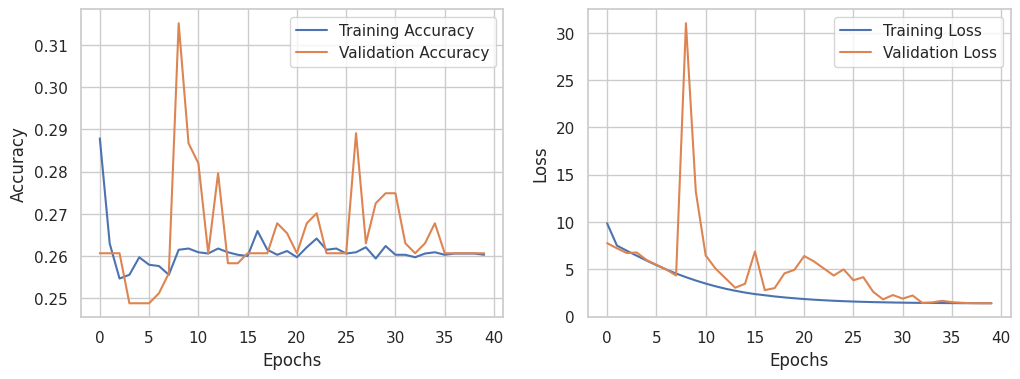

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###Model Evaluation and Image Prediction for Ophthalmic Image Classification

In [ ]:
# model.save('{}Eye_Diseases_InceptionResntV2.h5'.format(currentDir))

In [ ]:
model.save('{}Eye_Diseases_InceptionResntV2.keras'.format(currentDir))

In [ ]:
model = load_model('{}Eye_Diseases_InceptionResntV2.keras'.format(currentDir))

In [ ]:
train_results = model.evaluate(train_set, verbose= 1)
valid_results = model.evaluate(valid_set, verbose= 1)
test_results = model.evaluate(test_set, verbose= 1)

print("\nTrain Loss: ", train_results[0])
print("Train Accuracy: ", train_results[1])
print('-' * 40)

print("Validation Loss: ", valid_results[0])
print("Validation Accuracy: ", valid_results[1])
print('-' * 40)

print("Test Loss: ", test_results[0])
print("Test Accuracy: ", test_results[1])

85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 518ms/step - accuracy: 0.2644 - loss: 1.4041
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 894ms/step - accuracy: 0.2574 - loss: 1.4083
211/211 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.2541 - loss: 1.4057

Train Loss:  1.4051811695098877
Train Accuracy:  0.2603023946285248
----------------------------------------
Validation Loss:  1.4068256616592407
Validation Accuracy:  0.2606635093688965
----------------------------------------
Test Loss:  1.4038416147232056
Test Accuracy:  0.2606635093688965


In [ ]:
class_names = list(test_set.class_indices.keys())

predictions = model.predict(test_set, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n", class_report)

211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.00      0.00      0.00       104
diabetic_retinopathy       0.26      1.00      0.41       110
            glaucoma       0.00      0.00      0.00       101
              normal       0.00      0.00      0.00       107

            accuracy                           0.26       422
           macro avg       0.07      0.25      0.10       422
        weighted avg       0.07      0.26      0.11       422



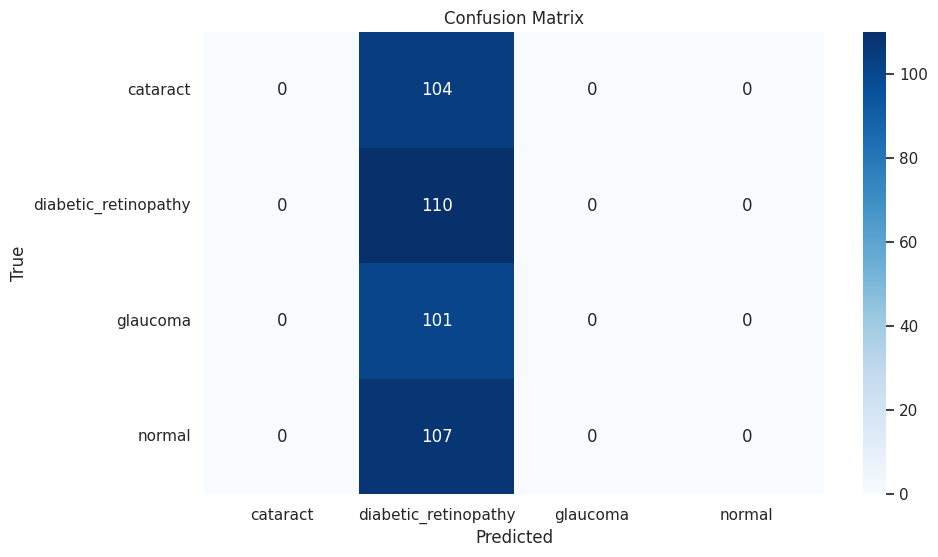

In [ ]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


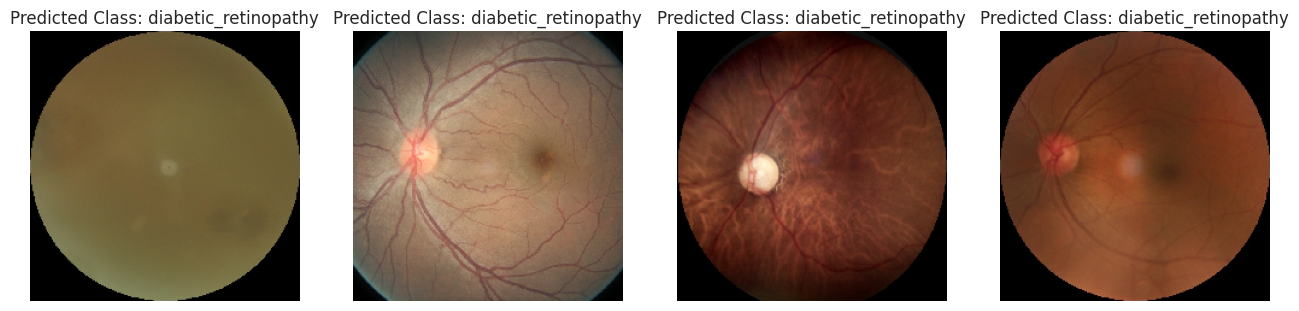

In [ ]:
def predict_and_display_images(image_paths, model):
    class_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        ax = axes[i]
        ax.imshow(img[0] / 255.0)
        ax.set_title(f"Predicted Class: {predicted_class}")
        ax.axis('off')

    plt.show()

image_paths = [
    '{}dataset/cataract/0_left.jpg'.format(currentDir),
    '{}dataset/diabetic_retinopathy/10009_right.jpeg'.format(currentDir),
    '{}dataset/glaucoma/1212_left.jpg'.format(currentDir),
    '{}dataset/normal/2329_left.jpg'.format(currentDir)
]


predict_and_display_images(image_paths, model)

###Activation Map Visualization and Attention Map Generation

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


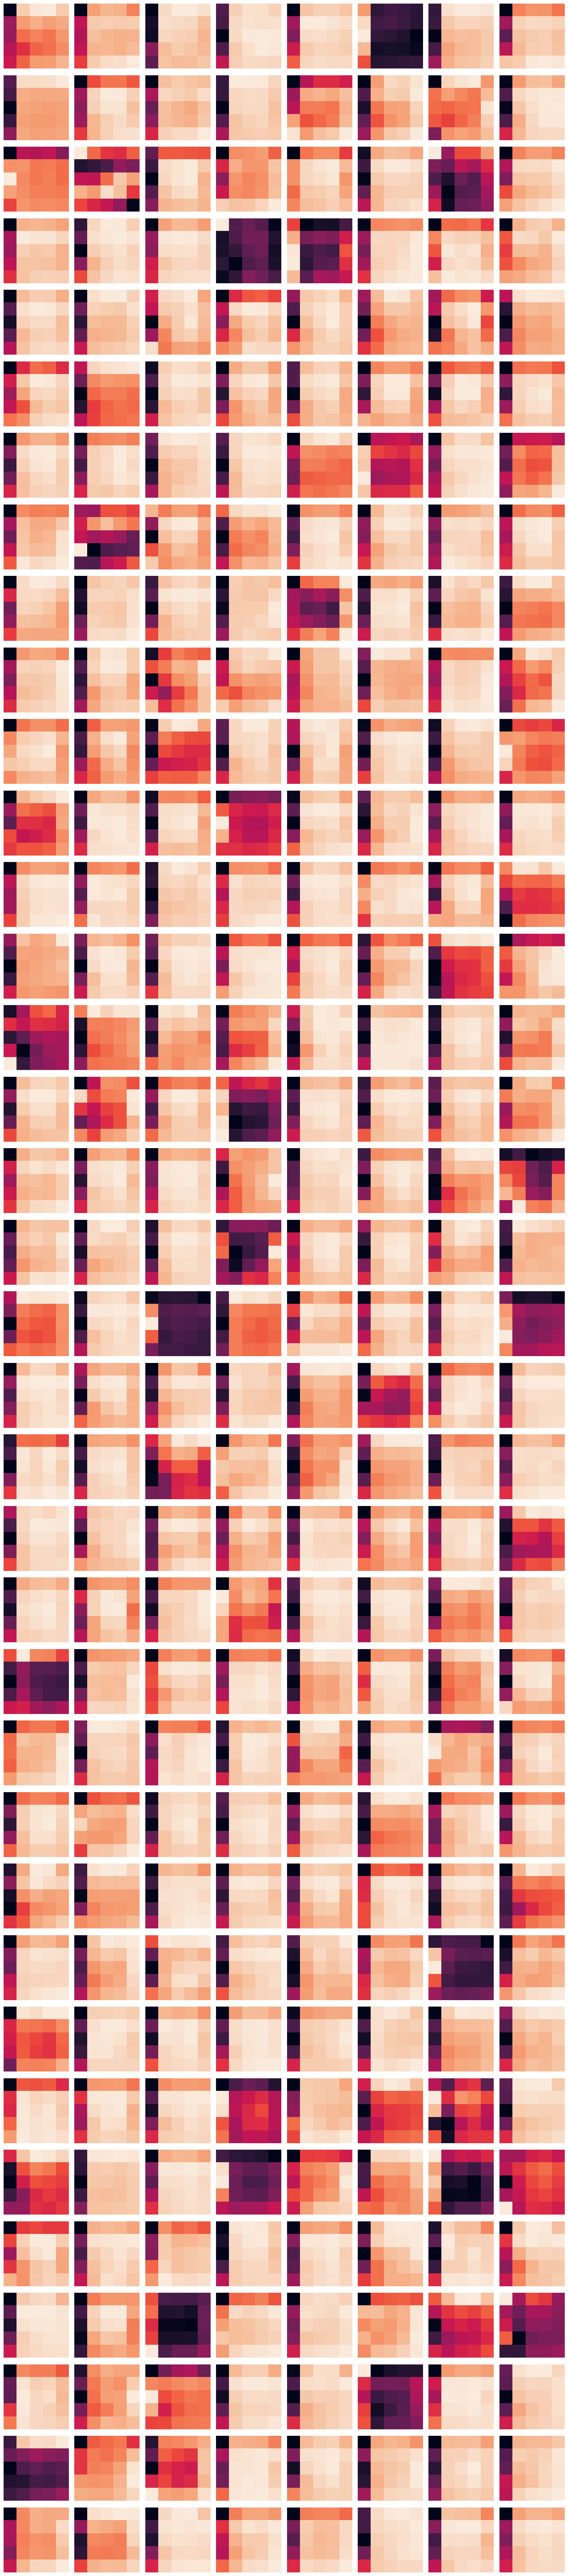

In [ ]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_565'
img_path = '{}dataset/glaucoma/1020_left.jpg'.format(currentDir)

visualize_activation_maps(model, img_path, layer_name)

Squeezed prediction: tf.Tensor([0.24590746 0.2603581  0.2388892  0.25484526], shape=(4,), dtype=float32)


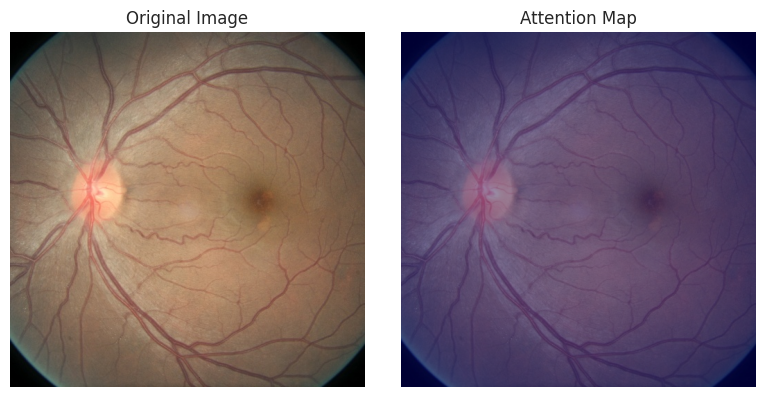

In [ ]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # print("Prediction:", predictions)
        # class_index = tf.argmax(predictions[0])
        # print(class_index)
        # loss = predictions[:, class_index]

        predictions = tf.squeeze(predictions)  # Ensure it's a tensor with correct shape
        print("Squeezed prediction:", predictions)
        class_index2 = tf.argmax(predictions)
        loss = predictions[class_index2]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '{}dataset/diabetic_retinopathy/10009_right.jpeg'.format(currentDir)
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv_7b_ac'
heatmap = get_gradcam(model, img_array, layer_name)

visualize_attention(image_path, heatmap)

##Convolutional Neural Network(CNN)

###Convolutional Neural Network Architecture

In [ ]:
model = Sequential()

model.add(Conv2D(32, (7, 7), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(4, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

###Training the Model

In [ ]:
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = 'Eye_Diseases_CNN.h5',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max',
    verbose = 1
)

In [ ]:
history_cnn = model.fit(x= train_set,
                        epochs= 50,
                        verbose= 1,
                        validation_data= valid_set,
                        callbacks = [checkpoint_callback]
)

###Training and Validation Performance Visualization

In [ ]:
train_accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###Model Evaluation and Image Prediction for Ophthalmic Image Classification

In [ ]:
model = load_model("/content/Eye_Diseases_CNN.h5")

In [ ]:
train_results = model.evaluate(train_set, verbose= 1)
valid_results = model.evaluate(valid_set, verbose= 1)
test_results = model.evaluate(test_set, verbose= 1)

print("\nTrain Loss: ", train_results[0])
print("Train Accuracy: ", train_results[1])
print('-' * 40)

print("Validation Loss: ", valid_results[0])
print("Validation Accuracy: ", valid_results[1])
print('-' * 40)

print("Test Loss: ", test_results[0])
print("Test Accuracy: ", test_results[1])

In [ ]:
class_names = list(test_set.class_indices.keys())

predictions = model.predict_generator(test_set, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n", class_report)

In [ ]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def predict_and_display_images(image_paths, model):
    class_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        ax = axes[i]
        ax.imshow(img[0] / 255.0)
        ax.set_title(f"Predicted Class: {predicted_class}")
        ax.axis('off')

    plt.show()

image_paths = [
    '/content/dataset/cataract/0_left.jpg',
    '/content/dataset/diabetic_retinopathy/10009_right.jpeg',
    '/content/dataset/glaucoma/1212_left.jpg',
    '/content/dataset/normal/2329_left.jpg'
]


predict_and_display_images(image_paths, model)

###Activation Map Visualization and Attention Map Generation

In [ ]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_203'
img_path = '/content/dataset/glaucoma/1020_left.jpg'

visualize_activation_maps(model, img_path, layer_name)

In [ ]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/dataset/diabetic_retinopathy/10009_right.jpeg'
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv2d_207'
heatmap = get_gradcam(model, img_array, layer_name)

visualize_attention(image_path, heatmap)

##Convolutional Neural Network(CNN)

###Convolutional Neural Network with Parallel Convolution Architecture

In [ ]:
def parallel_convolution_blocks(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv1x1_3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_3x3)

    conv1x1_5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_5x5)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_maxpool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    feature_fusion = concatenate([conv1x1, conv3x3, conv5x5, conv1x1_maxpool], axis=-1)
    return feature_fusion

input = Input(shape=(224, 224, 3))
x = input

x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = parallel_convolution_blocks(x, [64, 128, 128, 32, 32, 32])
x = parallel_convolution_blocks(x, [128, 192, 96, 64, 64, 64])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = parallel_convolution_blocks(x, [32, 64, 64, 16, 16, 32])
x = parallel_convolution_blocks(x, [64, 192, 128, 64, 64, 32])
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

x = parallel_convolution_blocks(x, [64, 128, 128, 32, 32, 32])
x = parallel_convolution_blocks(x, [128, 192, 96, 128, 128, 128])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(4, activation='softmax')(x)

model = Model(input, output)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


model.summary()

###Training the Model

In [ ]:
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = 'Eye_Diseases_CNN_with_Parallel_Convolution.h5',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max',
    verbose = 1
)

In [ ]:
history = model.fit(
    train_set,
    validation_data = valid_set,
    epochs = 50,
    callbacks = [checkpoint_callback],
    verbose = 1
)

###Training and Validation Performance Visualization

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###Model Evaluation and Image Prediction for Ophthalmic Image Classification

In [ ]:
model = load_model("/content/Eye_Diseases_CNN_with_Parallel_Convolution.h5")

In [ ]:
train_results = model.evaluate(train_set, verbose= 1)
valid_results = model.evaluate(valid_set, verbose= 1)
test_results = model.evaluate(test_set, verbose= 1)

print("\nTrain Loss: ", train_results[0])
print("Train Accuracy: ", train_results[1])
print('-' * 40)

print("Validation Loss: ", valid_results[0])
print("Validation Accuracy: ", valid_results[1])
print('-' * 40)

print("Test Loss: ", test_results[0])
print("Test Accuracy: ", test_results[1])

In [ ]:
class_names = list(test_set.class_indices.keys())

predictions = model.predict_generator(test_set, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n", class_report)

In [ ]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def predict_and_display_images(image_paths, model):
    class_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        ax = axes[i]
        ax.imshow(img[0] / 255.0)
        ax.set_title(f"Predicted Class: {predicted_class}")
        ax.axis('off')

    plt.show()

image_paths = [
    '/content/dataset/cataract/0_left.jpg',
    '/content/dataset/diabetic_retinopathy/10009_right.jpeg',
    '/content/dataset/glaucoma/1212_left.jpg',
    '/content/dataset/normal/2329_left.jpg'
]


predict_and_display_images(image_paths, model)

###Activation Map Visualization and Attention Map Generation

In [ ]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_148'
img_path = '/content/dataset/glaucoma/1020_left.jpg'

visualize_activation_maps(model, img_path, layer_name)

In [ ]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/dataset/diabetic_retinopathy/10009_right.jpeg'
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv2d_148'
heatmap = get_gradcam(model, img_array, layer_name)

visualize_attention(image_path, heatmap)